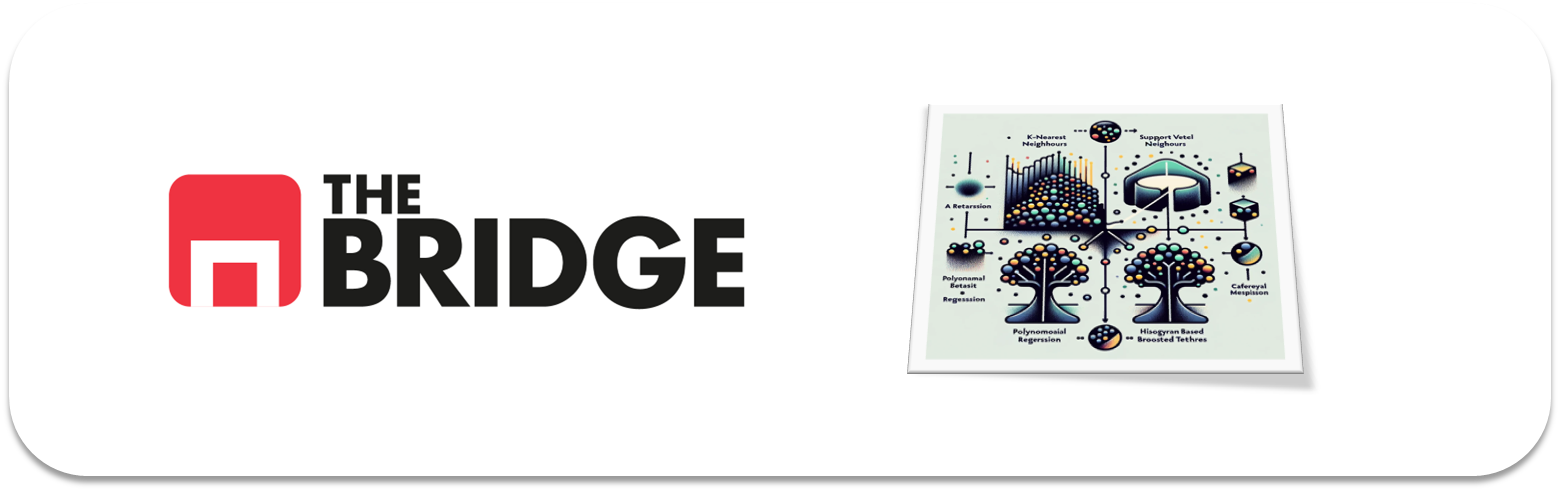

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVR


In [2]:
def describe_df(df):
    tipos = df.dtypes
    nulos_porcentaje = df.isnull().mean() * 100
    unicos = df.nunique()
    cardinalidad_porcentaje = unicos / len(df) * 100

    df_describe = pd.DataFrame({
        "Tipo": tipos,
        "Porcentaje_Nulos": nulos_porcentaje,
        "Valores_Unicos": unicos,
        "Porcentaje_Cardinalidad": cardinalidad_porcentaje
    })
    return df_describe

In [3]:
def classfeatures(df, target):
    features_num = []
    features_cat = []

    for col in df.columns:
        if df[col].dtypes != "object" and col != target:
            features_num.append(col)

        else:
            if col != target:
                features_cat.append(col)
    return features_cat, features_num

In [4]:
def bivariante_cat(df, cat_col1, cat_col2,  show_values= True):
    """
    Función que crea una gráfica que compara las 
    frecuencias relativas dedos variables categóricas 
    """
    
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    
    count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data, palette= "Set2")

    plt.title(f'Relación entre {cat_col1} y {cat_col2}')
    plt.xlabel(cat_col1)
    plt.ylabel('Frecuencia Relativa')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

In [5]:
def histograma_bivariante(df, columna_num, columna_cat):
    """
    Función que pinta los histogramas de una variable numérica y una varible categórica 
    para realizar un análisis bivariante
    """
    plt.figure(figsize=(6, 4))
    sns.histplot(data = df, x= columna_num, hue = columna_cat, kde = True, palette= "Set2")
    

    plt.title(f'Análisis Bivariante entre {columna_num} y {columna_cat}')
    plt.xlabel(columna_num)
    plt.show()

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [6]:
df= pd.read_csv("./data/wines_dataset.csv", sep = "|")
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.210,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.160,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.180,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.260,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.630,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
5,5.7,0.265,0.28,6.90,0.036,46.0,150.0,0.99299,3.36,0.44,10.8,7,white
6,6.6,0.210,0.31,11.40,0.039,46.0,165.0,0.99795,3.41,0.44,9.8,7,white
7,6.7,0.310,0.30,2.10,0.038,18.0,130.0,0.99280,3.36,0.63,10.6,6,white
8,8.9,0.750,0.14,2.50,0.086,9.0,30.0,0.99824,3.34,0.64,10.5,5,red
9,7.5,0.420,0.20,1.40,0.060,15.0,168.0,0.99440,3.06,0.40,9.4,6,white


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [8]:
describe_df(df)

,Tipo,Porcentaje_Nulos,Valores_Unicos,Porcentaje_Cardinalidad
fixed acidity,float64,0.0,106,1.631522
volatile acidity,float64,0.0,187,2.878252
citric acid,float64,0.0,89,1.369863
residual sugar,float64,0.0,316,4.863783
chlorides,float64,0.0,214,3.293828
free sulfur dioxide,float64,0.0,135,2.077882
total sulfur dioxide,float64,0.0,276,4.248115
density,float64,0.0,998,15.360936
pH,float64,0.0,108,1.662306
sulphates,float64,0.0,111,1.708481


In [9]:
target_clf= "quality"

In [10]:
df[target_clf].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

<Axes: xlabel='quality', ylabel='percent'>

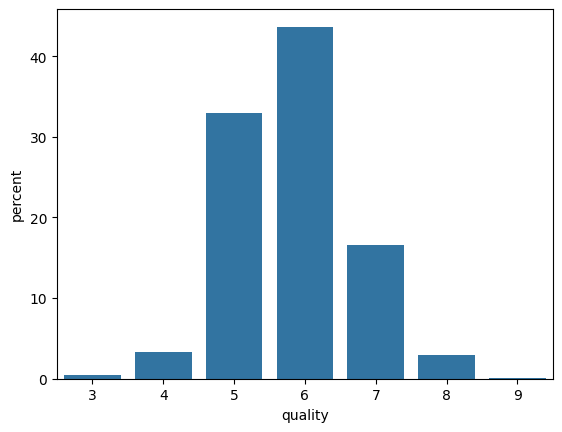

In [11]:
sns.countplot(df,x=target_clf,stat= "percent")

- La variable "quality" que nos dice la calidad del vino será la target de nuestro modelo de clasificación. Ésta desbalanceada, y ese desequilibrio tendremos que compensarlo para obtener un buen recall medio.

In [12]:
target_rg = "alcohol"
df[target_rg].value_counts()

alcohol
9.500000     367
9.400000     332
9.200000     271
10.000000    229
10.500000    227
            ... 
11.550000      1
12.333333      1
10.566667      1
10.750000      1
11.433333      1
Name: count, Length: 111, dtype: int64

<Axes: xlabel='alcohol', ylabel='Count'>

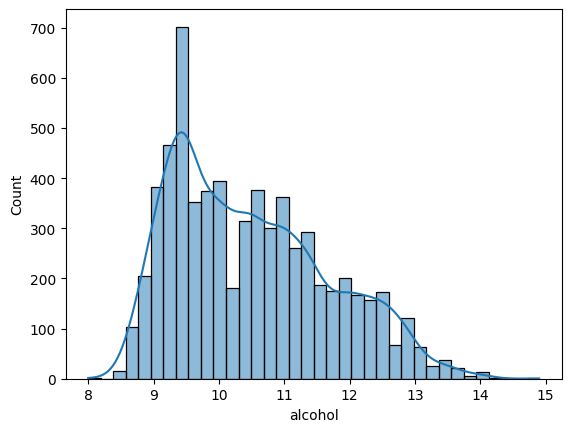

In [13]:
sns.histplot(df, x= target_rg, kde = True)

- La distribución de la variable "alcohol" que será la target para el modelo de regresión tiene una distrubución bastante simetrica.

In [14]:
train_set_clf, test_set_clf= train_test_split(df, test_size=0.2,stratify= df["quality"], random_state=73)

In [15]:
train_set_rg,test_set_rg = train_test_split(df, test_size=0.2, random_state=73)

**MINIEDA**

In [16]:
features_cat_clf, features_num_clf= classfeatures(train_set_clf, target= target_clf)

In [17]:
features_cat_clf

['class']

In [18]:
features_num_clf

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [19]:
features_cat_rg, features_num_rg= classfeatures(train_set_rg, target= target_rg)

In [20]:
features_num_rg

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'quality']

In [21]:
features_cat_rg

['class']

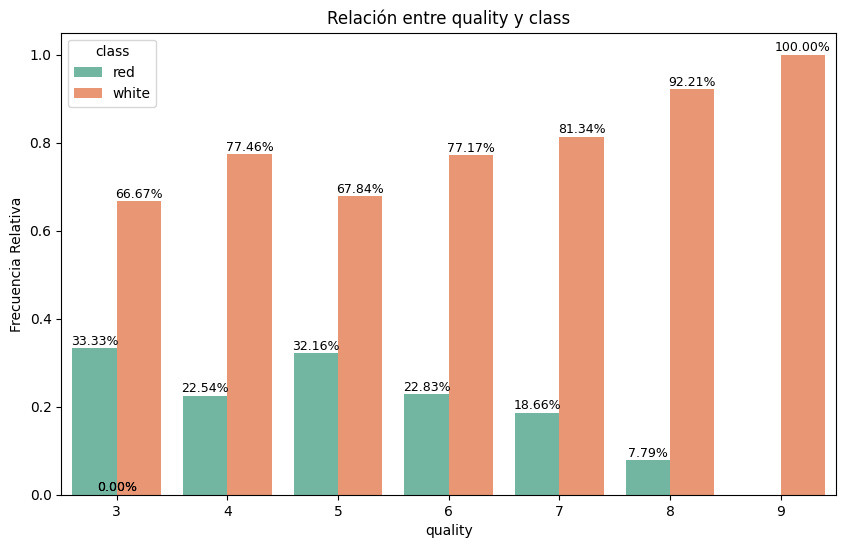

In [22]:
bivariante_cat(train_set_clf,target_clf,"class")

- Me la quedo para hacer mi modelo porque observamos que los vinos blancos son de mayor calidad que los tintos, de hecho en la categoría 9 no hay vinos tintos.

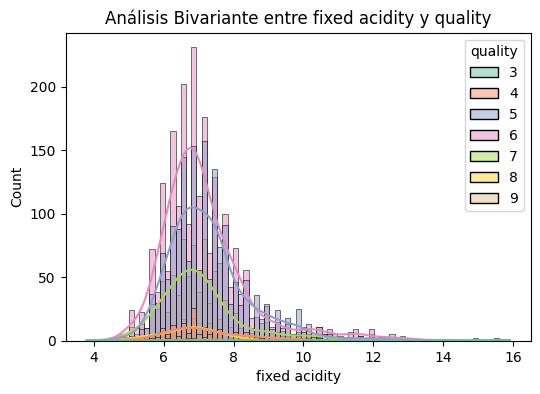

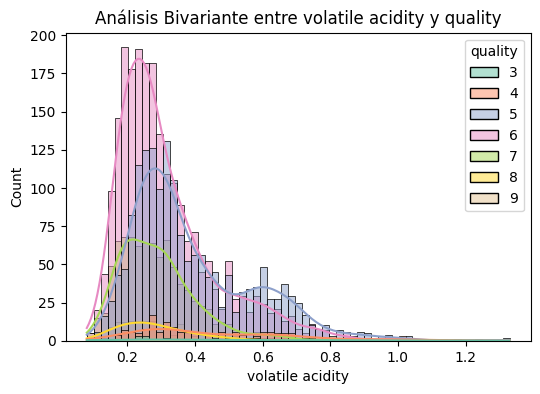

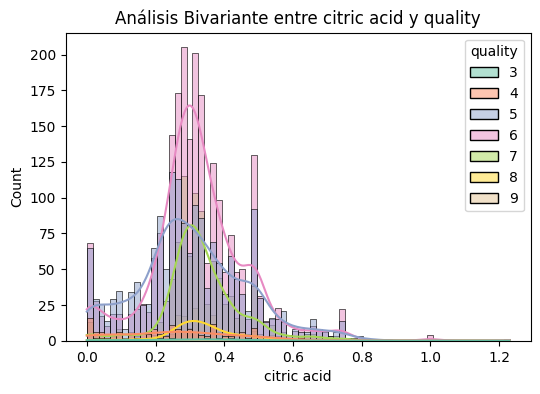

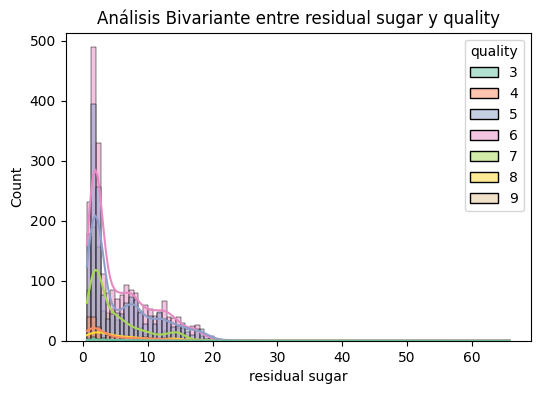

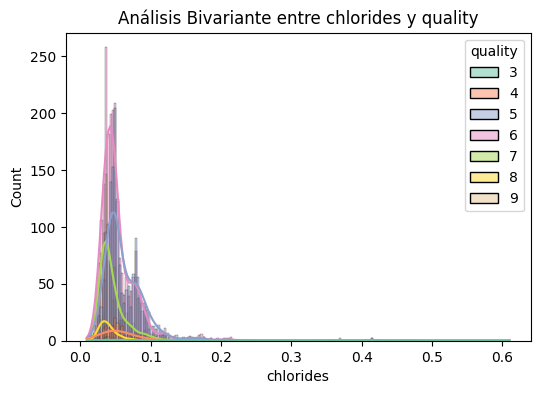

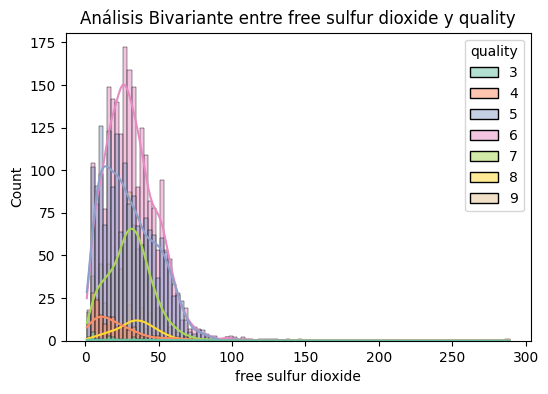

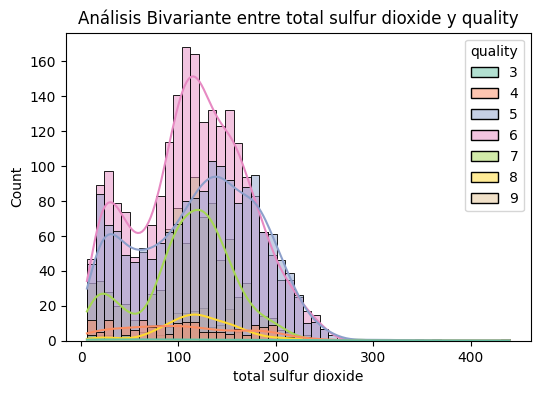

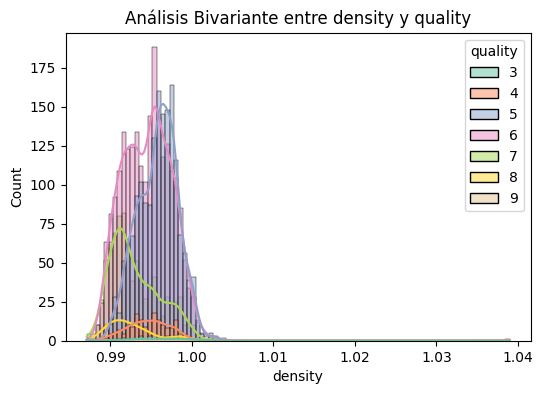

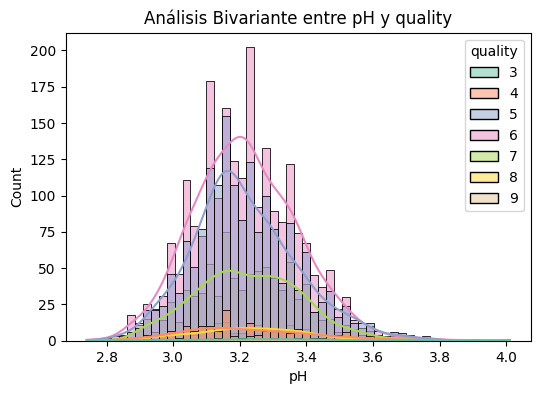

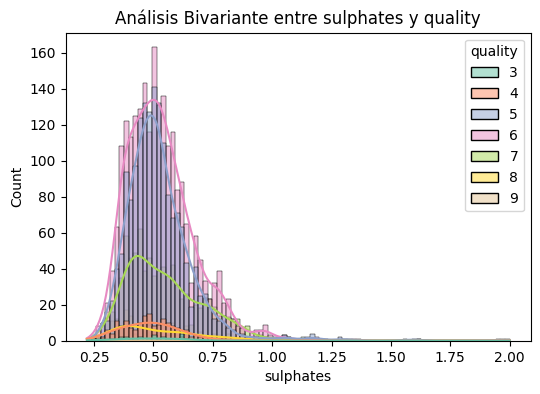

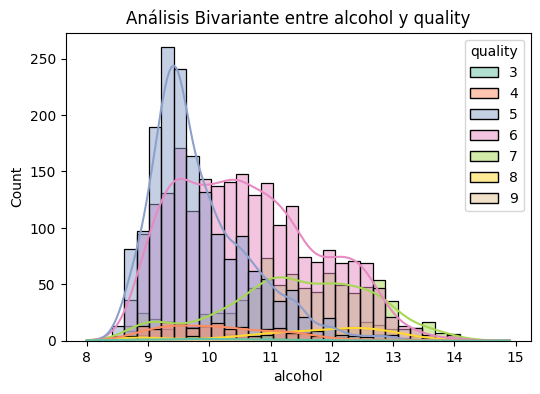

In [23]:
for feat in features_num_clf:
    histograma_bivariante(train_set_clf, feat, target_clf)

<Axes: >

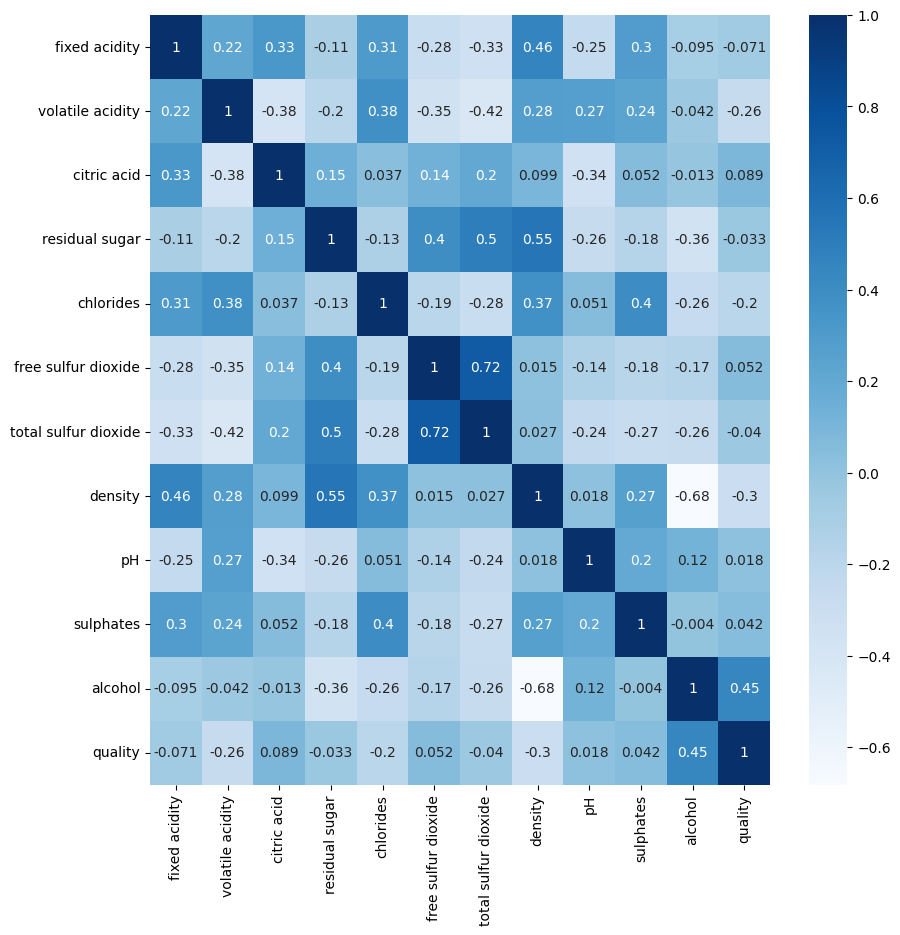

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(train_set_clf.corr(numeric_only=True), annot= True, cmap = "Blues")

In [25]:
corr = np.abs(train_set_clf.corr(numeric_only=True)[target_clf].sort_values(ascending=False))
corr

quality                 1.000000
alcohol                 0.445007
citric acid             0.089091
free sulfur dioxide     0.052115
sulphates               0.041608
pH                      0.018158
residual sugar          0.032505
total sulfur dioxide    0.040468
fixed acidity           0.070891
chlorides               0.201419
volatile acidity        0.261963
density                 0.300967
Name: quality, dtype: float64

In [26]:
# Me creo una lista con las features que más se relacionan con la target de la clasificación
f_corr_clf= ["alcohol", "chlorides", "volatile acidity","density"]

- Tratamiento de Features Numericas

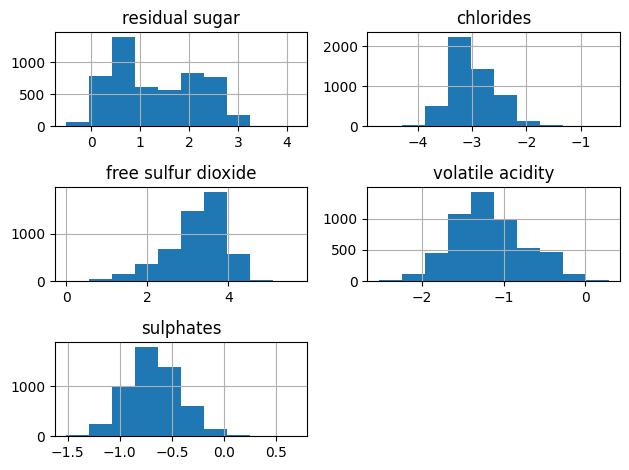

In [27]:
#Le voy a hacer el logaritmo a éstas feauteres para dejarlas más normalizadas
f_log= ['residual sugar', 'chlorides', 'free sulfur dioxide', 'volatile acidity', "sulphates"]
for feature in f_log:
    train_set_clf[feature] = train_set_clf[feature].apply(np.log)
    train_set_rg[feature] = train_set_rg[feature].apply(np.log)

train_set_clf[f_log].hist()
plt.tight_layout();

In [28]:
#Se lo hago al test
f_log= ['residual sugar', 'chlorides', 'free sulfur dioxide', 'volatile acidity', "sulphates"]
for feature in f_log:
    test_set_clf[feature] = test_set_clf[feature].apply(np.log)
    test_set_rg[feature] = test_set_rg[feature].apply(np.log)

In [29]:
#Estandarizo las features numericas del train y test del ejercicio de clasificacion
stc= StandardScaler()
train_set_clf[features_num_clf] = stc.fit_transform(train_set_clf[features_num_clf])
test_set_clf[features_num_clf] = stc.transform(test_set_clf[features_num_clf])

In [34]:
#Ahora las del ejercicio de regresión
stc_rg= StandardScaler()
train_set_rg[features_num_rg] = stc_rg.fit_transform(train_set_rg[features_num_rg])
test_set_rg[features_num_rg] = stc_rg.transform(test_set_rg[features_num_rg])

- Tratamiento de Features Categoricas

In [30]:
#Por último voy hacerle un OneHotEncoder a la variable "class"
train_set_clf = pd.get_dummies(train_set_clf, columns=["class"], dtype = int)
test_set_clf  = pd.get_dummies(test_set_clf, columns =["class"], dtype = int)
train_set_rg = pd.get_dummies(train_set_rg, columns=["class"], dtype = int)
test_set_rg  = pd.get_dummies(test_set_rg, columns =["class"], dtype = int)

In [31]:
features_cat_clf.append("class_red")
features_cat_clf.append("class_white")
features_cat_clf.remove("class")

In [32]:
features_cat_rg.append("class_red")
features_cat_rg.append("class_white")
features_cat_rg.remove("class")

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

- Haré varios modelos con las diferentes listas de features que cree, el baseline será el KNN, haré una Random Forest Classifier y un XGBoost Classifier

In [33]:
X_train_clf = train_set_clf[features_cat_clf + features_num_clf]
y_train_clf = train_set_clf[target_clf]
X_test_clf = test_set_clf[features_cat_clf + features_num_clf]
y_test_clf = test_set_clf[target_clf]

In [34]:
k_range = range(1,40)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(k)
    scores.append(cross_val_score(knn, X_train_clf, y_train_clf, cv = 3, scoring = "balanced_accuracy").mean())

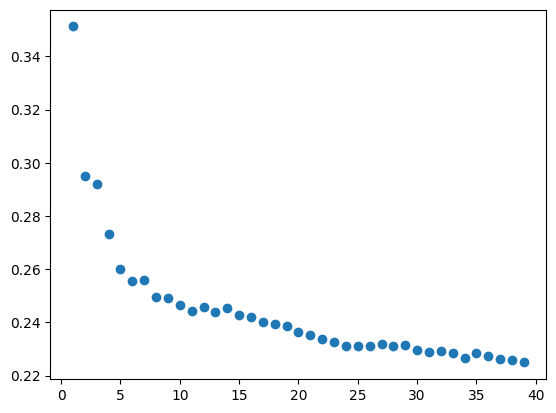

In [35]:
plt.scatter(k_range,scores);

In [37]:
modelos = {
    "KNN":KNeighborsClassifier(n_neighbors=2),
    "RandomForest":RandomForestClassifier(),
    "LGBMClassifier":LGBMClassifier(verbose = -100),
}

resultados = {}

for modelo, estimador in modelos.items():
    media = cross_val_score(estimador, X_train_clf, y_train_clf, cv=5, scoring= 'balanced_accuracy').mean()
    resultados[modelo] = [media]


c:\Users\vanep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\vanep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\vanep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\vanep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [38]:
pd.DataFrame(data = resultados)

,KNN,RandomForest,LGBMClassifier
0,0.311914,0.364116,0.359629


In [41]:
param_grid = {"n_estimators": [200,300,500],
    "max_depth": [3,6,9],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "class_weight": ["balanced", None]
}

rf_clf = RandomForestClassifier(random_state= 42)

rf_grid = GridSearchCV(rf_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train_clf, y_train_clf)

c:\Users\vanep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [200, 300, 500]},
             scoring='balanced_accuracy')

In [43]:
print("Random_forest_score:", rf_grid.best_score_)
print("Random_forest_params:", rf_grid.best_params_)

Random_forest_score: 0.39139715272800557
Random_forest_params: {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 500}


In [44]:
print(classification_report(y_train_clf, rf_grid.predict(X_train_clf)))

              precision    recall  f1-score   support

           3       0.38      1.00      0.55        24
           4       0.28      0.78      0.42       173
           5       0.60      0.69      0.64      1710
           6       0.72      0.28      0.40      2269
           7       0.44      0.69      0.54       863
           8       0.34      0.92      0.50       154
           9       0.80      1.00      0.89         4

    accuracy                           0.52      5197
   macro avg       0.51      0.77      0.56      5197
weighted avg       0.60      0.52      0.51      5197



In [45]:
feature_importance = rf_grid.best_estimator_.feature_importances_
df_feature_importance = pd.DataFrame(feature_importance,columns=['Importance'], index=X_train_clf.columns)
df_feature_importance.sort_values('Importance', ascending=False)

,Importance
alcohol,0.144707
chlorides,0.139943
density,0.113293
free sulfur dioxide,0.097745
fixed acidity,0.088717
volatile acidity,0.086643
total sulfur dioxide,0.080612
citric acid,0.063807
pH,0.060452
residual sugar,0.060270


In [46]:
#Voy a crear un nuevo juego de X,y train y test solo con las features que están más correlacionandas con la target y que concuerdan con las
#features importances que nos da el grid
X_train_clf_corr = train_set_clf[f_corr_clf]
y_train_clf_corr = train_set_clf[target_clf]
X_test_clf_corr= test_set_clf[f_corr_clf]
y_test_clf_corr= test_set_clf[target_clf]

In [47]:
rf_clf_corr = RandomForestClassifier(random_state= 42)

rf_grid_corr = GridSearchCV(rf_clf_corr,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

rf_grid_corr.fit(X_train_clf_corr, y_train_clf_corr)

c:\Users\vanep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [200, 300, 500]},
             scoring='balanced_accuracy')

In [48]:
print("Random_forest_score:", rf_grid_corr.best_score_)
print("Random_forest_params:", rf_grid_corr.best_params_)

Random_forest_score: 0.3477306539887536
Random_forest_params: {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 200}


In [50]:
print(classification_report(y_train_clf_corr, rf_grid_corr.predict(X_train_clf_corr)))

              precision    recall  f1-score   support

           3       0.39      1.00      0.56        24
           4       0.29      0.60      0.39       172
           5       0.61      0.67      0.64      1728
           6       0.67      0.31      0.43      2245
           7       0.45      0.71      0.55       864
           8       0.34      0.91      0.49       159
           9       0.16      1.00      0.28         5

    accuracy                           0.53      5197
   macro avg       0.42      0.74      0.48      5197
weighted avg       0.59      0.53      0.52      5197



- No hay mucha diferencia entre el modelo con todas las features y el modelo que solo tiene las features más correlacionadas, de hecho da algunos datos un poco peor. Me quedaré con el modelo con todas las features y voy a hacer un sobremuestreo para ver si puedo mejorar el recall medio.

In [49]:
y_train_clf.value_counts()

quality
6    2269
5    1710
7     863
4     173
8     154
3      24
9       4
Name: count, dtype: int64

In [51]:
smote = SMOTE(k_neighbors= 3, random_state=42)
X_train_clf_smote, y_train_clf_smote = smote.fit_resample(X_train_clf, y_train_clf)

In [52]:
y_train_clf_smote.value_counts()

quality
6    2269
5    2269
7    2269
8    2269
4    2269
3    2269
9    2269
Name: count, dtype: int64

In [53]:
modelos = {
    "KNN":KNeighborsClassifier(n_neighbors=2),
    "RandomForest":RandomForestClassifier(),
    "LGBMClassifier":LGBMClassifier(verbose= -100),
}

resultados = {}

for modelo, estimador in modelos.items():
    media = cross_val_score(estimador, X_train_clf_smote, y_train_clf_smote, cv=5, scoring= 'balanced_accuracy').mean()
    resultados[modelo] = [media]


In [54]:
pd.DataFrame(data = resultados)

,KNN,RandomForest,LGBMClassifier
0,0.882077,0.905437,0.881891


- Los modelos han mejorado mucho con el sobremuestreo, me quedo nuevamente con el RandomForest, le hare un grid y finalmente hago la prueba contra el test.

In [56]:
param_grid_smote = {"n_estimators": [200,300,500],
    "max_depth": [3,6,9],
    "min_samples_leaf": [10,20],
    "max_features": ["sqrt","log2"],
}

rf_clf_smote = RandomForestClassifier(random_state= 42)

rf_grid_smote = GridSearchCV(rf_clf_smote,
                       param_grid= param_grid_smote,
                       cv = 5,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

rf_grid_smote.fit(X_train_clf_smote, y_train_clf_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 20],
                         'n_estimators': [200, 300, 500]},
             scoring='balanced_accuracy')

In [57]:
print("Random_forest_score:", rf_grid_smote.best_score_)
print("Random_forest_params:", rf_grid_smote.best_params_)

Random_forest_score: 0.7713956463934583
Random_forest_params: {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}


In [58]:
print(classification_report(y_train_clf_smote, rf_grid_smote.predict(X_train_clf_smote)))

              precision    recall  f1-score   support

           3       0.97      0.97      0.97      2269
           4       0.82      0.88      0.85      2269
           5       0.60      0.72      0.66      2269
           6       0.67      0.40      0.50      2269
           7       0.75      0.78      0.77      2269
           8       0.89      0.94      0.92      2269
           9       0.98      1.00      0.99      2269

    accuracy                           0.81     15883
   macro avg       0.81      0.81      0.81     15883
weighted avg       0.81      0.81      0.81     15883



              precision    recall  f1-score   support

           3       0.06      0.17      0.09         6
           4       0.16      0.53      0.25        43
           5       0.53      0.64      0.58       428
           6       0.60      0.30      0.40       567
           7       0.44      0.56      0.49       216
           8       0.29      0.51      0.37        39
           9       0.17      1.00      0.29         1

    accuracy                           0.47      1300
   macro avg       0.32      0.53      0.35      1300
weighted avg       0.52      0.47      0.47      1300



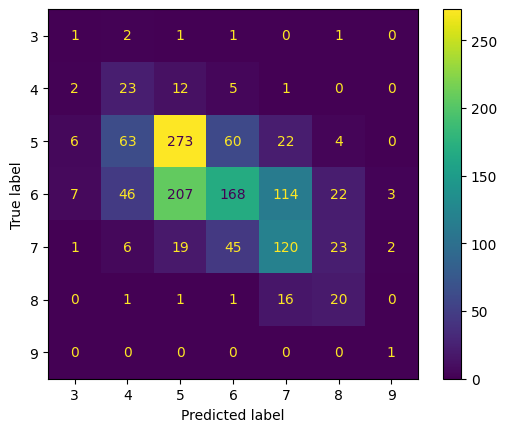

In [59]:
y_pred_clf = rf_grid_smote.best_estimator_.predict(X_test_clf)
print(classification_report(y_test_clf, y_pred_clf))
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_clf)

- Al hacer el sobremuestro las predicciones contra el train nos daba muy buenos valores (recall medio 77%) sin embargo al probarlo contra el test, el recall medio nos baja a un 53%, el modelo tiene dificultades para predir las clases minoritarias

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

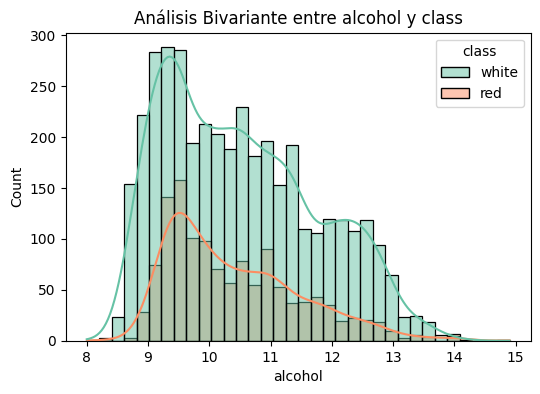

In [97]:
histograma_bivariante(train_set_rg,target_rg,"class")

In [60]:
corr = np.abs(train_set_rg.corr(numeric_only=True)[target_rg].sort_values(ascending=False))
corr

alcohol                 1.000000
quality                 0.446350
pH                      0.123746
class_white             0.037954
citric acid             0.008156
volatile acidity        0.029698
sulphates               0.031503
class_red               0.037954
fixed acidity           0.093280
free sulfur dioxide     0.131758
total sulfur dioxide    0.263126
residual sugar          0.306253
chlorides               0.376701
density                 0.687011
Name: alcohol, dtype: float64

In [62]:
# Selecciono éstas features que son las que tiene más correlación con la target de regresión pero no incluyo free sulfur dioxide porque tiene 
#una alta colinealidad con total sulfur dioxide
f_corr_rg = ["quality","pH", "chlorides", "total sulfur dioxide","density","residual sugar"]

- Ya éstan tratadas las features así que hago directamente el modelado

In [63]:
X_train_rg = train_set_rg[features_cat_rg + features_num_rg]
y_train_rg = train_set_rg[target_rg]
X_test_rg = test_set_rg[features_cat_rg + features_num_rg]
y_test_rg = test_set_rg[target_rg]

In [64]:
modelos_rg = {
    "LinearRegressor": LinearRegression(),
    "KNN":KNeighborsRegressor(n_neighbors=2),
    "SVM":SVR(),
    "RandomForest":RandomForestRegressor(random_state= 42),
    "LGBMRegressor":LGBMRegressor(random_state= 42, verbose = -100),
}

resultados_rg= {}

for modelo, estimador in modelos_rg.items():
    x = cross_val_score(estimador, X_train_rg, y_train_rg, cv=5, scoring='neg_mean_absolute_percentage_error')
    media = np.sqrt(-np.mean(x))
    resultados_rg[modelo] = [media]

In [65]:
pd.DataFrame(data = resultados_rg)

,LinearRegressor,KNN,SVM,RandomForest,LGBMRegressor
0,0.198538,0.255207,0.280623,0.162059,0.162818


In [66]:
X_train_rg_corr = train_set_rg[f_corr_rg]
y_train_rg_corr = train_set_rg[target_rg]
X_test_rg_corr = test_set_rg[f_corr_rg]
y_test_rg_corr = test_set_rg[target_rg]

In [72]:
modelos_rg_2 = {
    "LinearRegressor": LinearRegression(),
    "KNN":KNeighborsRegressor(n_neighbors=2),
    "SVM":SVR(),
    "RandomForest":RandomForestRegressor(random_state= 42),
    "LGBMRegressor":LGBMRegressor(random_state= 42, verbose = -100),
}

resultados_rg_2= {}

for modelo, estimador in modelos_rg_2.items():
    x = cross_val_score(estimador, X_train_rg_corr, y_train_rg_corr, cv=5, scoring='neg_mean_absolute_percentage_error')
    media = np.sqrt(-np.mean(x))
    resultados_rg_2[modelo] = [media]

In [73]:
pd.DataFrame(data = resultados_rg_2)

,LinearRegressor,KNN,SVM,RandomForest,LGBMRegressor
0,0.23147,0.260404,0.281237,0.178933,0.189653


- No obtengo mejores resultados entrenando a los modelos con las features más correlacionadas así que me quedo con el RandomForest entrenado con todas las features, le haré un GridSearch para intentar mejor el MAPE

In [76]:
params_grid_rg = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_rg = RandomForestRegressor(random_state= 42)

rf_grid_rg = GridSearchCV(rf_rg,
                       param_grid= params_grid_rg,
                       cv = 5,
                       scoring = 'neg_mean_absolute_percentage_error',
                       n_jobs = -1)

rf_grid_rg.fit(X_train_rg, y_train_rg)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_mean_absolute_percentage_error')

In [77]:
print("Random_forest_score:", rf_grid_rg.best_score_)
print("Random_forest_params:", rf_grid_rg.best_params_)

Random_forest_score: -0.033619021599641016
Random_forest_params: {'max_depth': 10, 'max_features': None, 'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 200}


In [78]:
y_pred_rg = rf_grid_rg.best_estimator_.predict(X_test_rg)
print("MAE:", mean_absolute_error(y_test_rg,y_pred_rg))
print("MAPE:", mean_absolute_percentage_error(y_test_rg,y_pred_rg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_rg, y_pred_rg)))

MAE: 0.35466204273347074
MAPE: 0.03373389498320186
RMSE: 0.4719848859295233


In [80]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

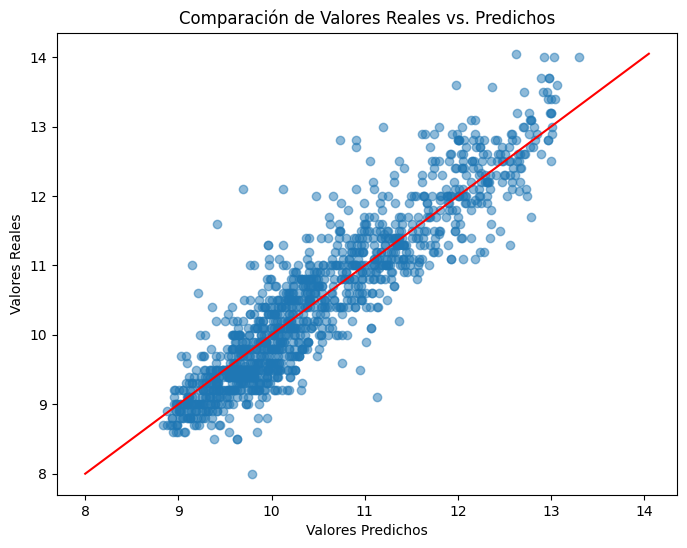

In [81]:
plot_predictions_vs_actual(y_test_rg,y_pred_rg)

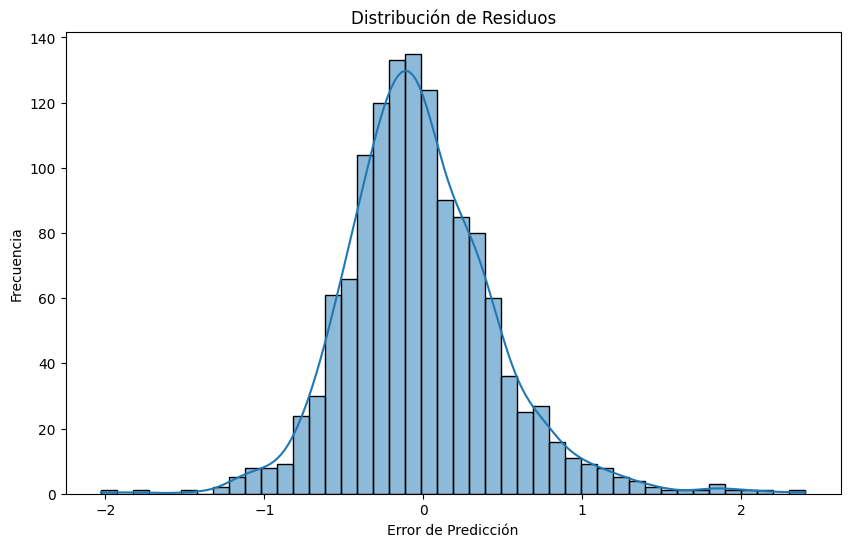

In [82]:
residuos = y_test_rg - y_pred_rg

# Visualización de residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de Residuos')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()

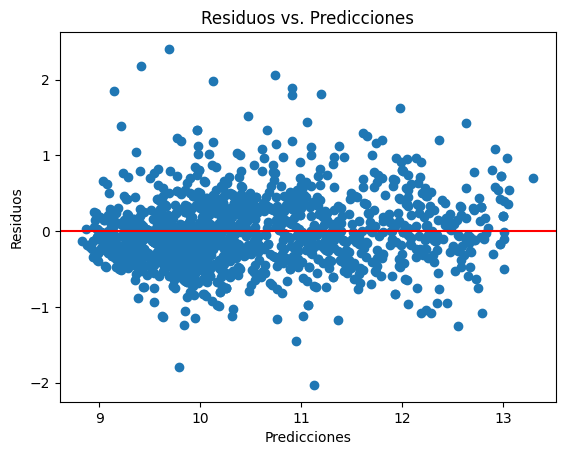

In [83]:
plt.scatter(y_pred_rg, residuos)
plt.title('Residuos vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

El modelo predice bastante bien, se equivoca en promedio un 3.4% en relación con los valores reales de grado de alcohol. Podemos ver en la gráfica donde comparamos los valores reales con los predichos que hay algunos valores que se alejan mucho de nuestra predicción, podemos buscar la manera de tratarlos para intentar mejorar el modelo. Los residuos se encuentran distribuidos normalmente, lo que es bueno.
En general el modelo predice bastante.